In [24]:
# Importing necessary libraries

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

plt.rcParams["figure.figsize"] = (15, 15)

In [25]:
# Importing necessary packages to be used

from tkinter import *
from PIL import Image
from PIL import ImageTk
import tkinter.filedialog as tkFileDialog
import cv2
from tkinter import messagebox

In [17]:
# Define all parameters like paths to image file, model, face detection models etc.
def define_parameters(path):
    
    print("DEFINING PARAMETERS...")
    
    global path_to_image, prototxt_path, weights_path, MIN_CONFIDENCE, path_to_model
    
    # Sample image
    path_to_image = path

    # Files needed for face detection
    prototxt_path = './Pretrained_face_detection_model_opencv/deploy.prototxt.txt'
    weights_path = './Pretrained_face_detection_model_opencv/res10_300x300_ssd_iter_140000.caffemodel'

    # Minimum probability to filter weak detections
    MIN_CONFIDENCE = 0.5

    # Trained mask detector model
    path_to_model = 'mask_detector_model.h5'

In [18]:
# Load all models

def load_models():
    print("LOADING MODELS...")
    
    global prototxt_path, weights_path
    
    # Load the face detector model
    # This face detection model is a pretrained model and is supported by opencv
    face_detection_dnn = cv2.dnn.readNet(prototxt_path, weights_path)

    # Loading the face mask detection model that was created by us
    model = load_model(path_to_model)
    model.summary()
    
    return face_detection_dnn, model

In [19]:
# Load the image which was selected by the user

def load_image():
    print("LOADING IMAGE...")
    
    global path_to_image
    image = cv2.imread(path_to_image)

    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.show()
    
    return image

In [20]:
# Detect all faces in the image using the pretrained model

def detect_faces(image, face_detection_dnn):
    print("DETECTING FACES...")
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    # we resize to 300×300 pixels and perform mean subtraction.

    # BLOB stands for Binary Large OBject and refers to a group of connected pixels in a binary image. 
    # The term "Large" indicates that only objects of a certain size are of interest 
    # and that the other "small" binary objects are usually noise.
    
    # pass the blob through the network and obtain the face detections

    face_detection_dnn.setInput(blob)
    face_detections = face_detection_dnn.forward()

    # Now we have all the detected faces and we know the location of each detected face
    # We will consider a face to be 'detected' if its confidence is greater than our minimum confidence
    
    return face_detections

In [21]:
# Detect if the images of the faces returned by the face detection model are wearing face masks

def detect_face_masks(image, model, face_detections):
    
    print("PERFORMING FACE MASK DETECTION...")
    height = image.shape[0]
    width = image.shape[1]

    # Iterate through all the face detections

    for i in range(face_detections.shape[2]):
        # Confidence or probability of currenct detection
        confidence = face_detections[0, 0, i, 2]

        # Detections with confidence higher than our threshold are only considered
        if confidence > MIN_CONFIDENCE:

            # Computing boundaries of the bounding box of the detected face
            detected_rectangle = face_detections[0, 0, i, 3:7] * np.array([width, height, width, height])
            (startX, startY, endX, endY) = detected_rectangle.astype("int")

            # Ensuring that the position of the detected face are within the boundaries of the image
            startX = max(0, startX)
            startY = max(0, startY)
            endX = min(endX, width-1)
            endY = min(endY, height-1)

            # Extracting and pre- processing the detected face
            face_img = image[startY:endY, startX:endX]
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
            face_img = cv2.resize(face_img, (224, 224))
            face_img = img_to_array(face_img)
            face_img = preprocess_input(face_img)
            face_img = np.expand_dims(face_img, axis=0)

            # Passing image through the model
            (mask, withoutMask) = model.predict(face_img)[0]

            # Output
            if mask > withoutMask:
                label = 'Mask detected'
                colour = (0,255,0)
            else:
                label = 'Mask NOT detected'
                colour = (0,0,255)

            label1 = label 
            label2 = 'Probability: {:.2f}%'.format(max(mask, withoutMask)*100)

            # Displaying output and rectangle
            cv2.putText(image, label1, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 4)
            cv2.rectangle(image, (startX, startY), (endX, endY), colour, 3)
            cv2.putText(image, label2, (startX, endY+30), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 4)

    rgb_final_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_final_img)
    plt.show()
    
    return image

In [22]:
# Call all functions

def perform_face_mask_detection(path):
    define_parameters(path)
    face_detection_dnn, model = load_models()
    image = load_image()
    face_detections = detect_faces(image, face_detection_dnn)
    final_img = detect_face_masks(image, model, face_detections)
    
    
    return final_img

# GUI CODE

/media/aprameya/New Volume/NITK Courses/Sem 4/IT290/Realtime_face_mask_detection/Dataset/samples/without_mask/sample3.jpg
DEFINING PARAMETERS...
LOADING MODELS...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
__________

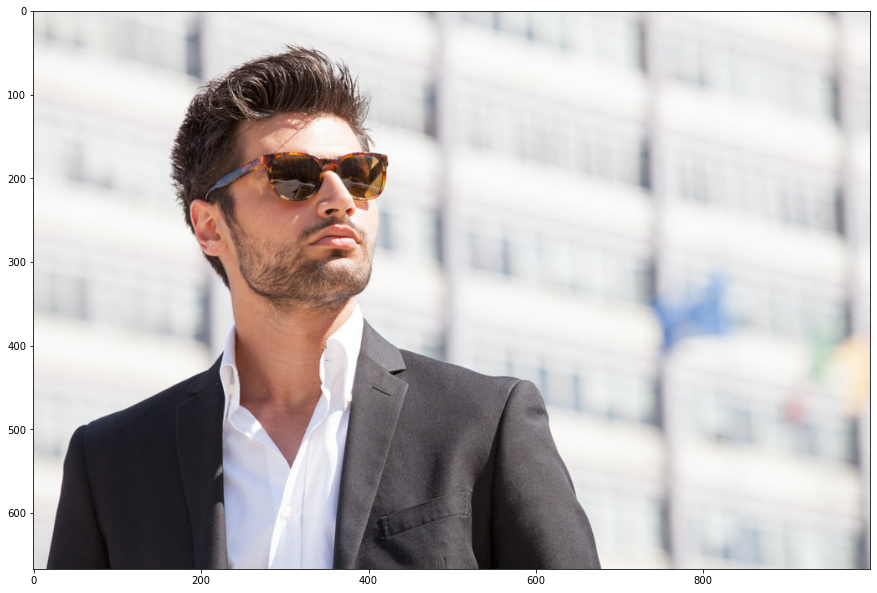

DETECTING FACES...
PERFORMING FACE MASK DETECTION...


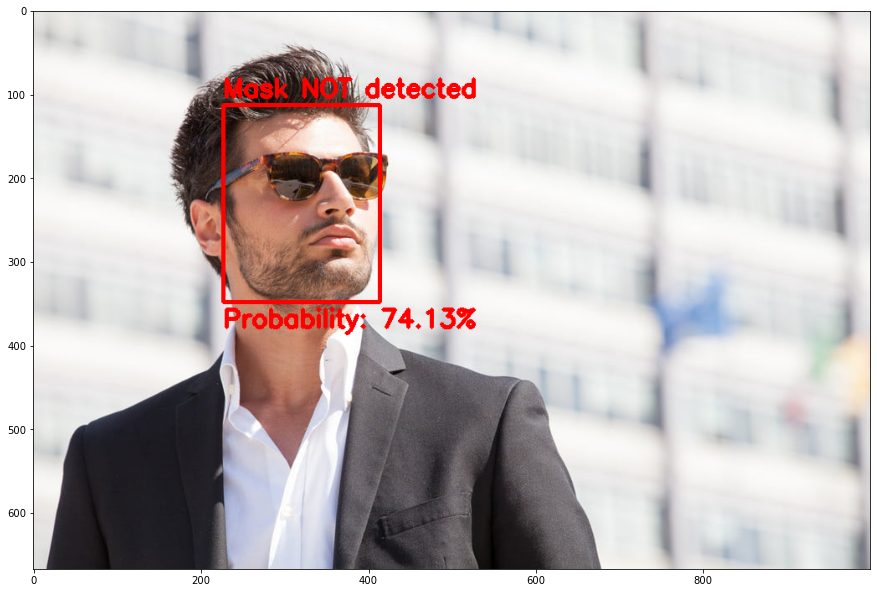

In [34]:
def display_image(image):
    #  represents images in BGR order; however PIL represents
    # images in RGB order, so we need to swap the channels

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (900, 700))

    # convert the images to PIL format...
    image = Image.fromarray(image)

    # ...and then to ImageTk format
    image = ImageTk.PhotoImage(image)

    canvas.image = image
    canvas.create_image(0, 0, anchor=NW, image=image) 

# This func is called whenever the 'Select an image' button is clicked
def select_image():
    # grab a reference to the image canvas and the path variable
    global canvas
    global path
    
    canvas.delete("all")
    # open a file chooser dialog and allow the user to select an input
    # image
    path = tkFileDialog.askopenfilename()

    # ensure a file path was selected
    if len(path) > 0 and (path[-4:] == '.jpg' or path[-5:] == '.jpeg' or path[:4] == '.png'):
        # load the image from disk
        image = cv2.imread(path)
        display_image(image)
        text2.config(text = "Image selected. Click submit to start processing!")
    else:
        messagebox.showinfo("Warning","Please choose an image! (It should be a .jpg file)")
                
# Submit the image for preprocessing if the image path is valid and the currency type is chosen

def submit():
    global path, text2
    if len(path) <= 0:
        messagebox.showinfo("Warning","Please choose an image!")
    else:
        print(path)
            
        text2.config(text = "Please wait! Processing Image...")
        final_img = perform_face_mask_detection(path)
        display_image(final_img)
        text2.config(text = "Results displayed!")


# Exit window
def exit_window():
    root.destroy()

    
# Main function
# Declaring root window
root = Tk() 
root.title("Fake Currency Detection System")

# Declaring the attributes of the GUI window
root.resizable(False, False)  # This code helps to disable windows from resizing

window_height = 950
window_width = 1100

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

x_cordinate = int((screen_width/2) - (window_width/2))
y_cordinate = int((screen_height/2) - (window_height/2))

root.geometry("{}x{}+{}+{}".format(window_width, window_height, x_cordinate, y_cordinate))

# Declaring variables
path = ""                      # Stores path of image selected


# create all of the main containers
top_frame = Frame(root, bg='black', width=1090, height=50, pady=3)
frame1 = Frame(root, bg='cyan', width=1090, height=80, padx=3, pady=3)
frame2 = Frame(root, bg='brown', width=1090, height=400, pady=5, padx = 5)
frame3 = Frame(root, width=1090, height=50, pady=3)
frame4 = Frame(root, width=1090, height=50, pady=3)
frame5 = Frame(root, bg='white', width=1090, height=20, pady=3)

# Assigning all frames in a grid layout on the root window
top_frame.grid(row = 1, column = 1, padx = 5, pady = 5)
frame1.grid(row = 2, column = 1, padx = 5, pady = 5)
frame2.grid(row = 3, column = 1, padx = 5, pady = 5)
frame3.grid(row = 4, column = 1, padx = 5, pady = 5)
frame4.grid(row = 5, column = 1, padx = 5, pady = 5)
frame5.grid(row = 6, column = 1, padx = 5, pady = 5)

# Title label
title = Label(master=top_frame, text="FACE MASK DETECTION SYSTEM", fg = 'dark blue', font = "Verdana 28 bold")
title.pack() # Put the label into the window

# Text label
text1 = Label(master=frame1, text="This is a face mask detection sytem. Browse and select your image file and get started!", fg = 'blue', font = "Verdana 15")
text1.pack() 

# Creating a canvas to display the image
canvas = Canvas(master=frame2, width = 900, height = 700)  
canvas.pack() 

# Status
text2 = Label(master=frame3, text="Image not selected!", fg = 'blue', font = "Verdana 15")
text2.pack() 

# Button to browse the image
btn_select_image = Button(master = frame4, text="Select an image", command=select_image, font = "Verdana 15 bold", fg='blue')
btn_select_image.pack(side = 'left', padx=10, pady=10)

# Button to submit the image
btn_submit = Button(master = frame4, text="Submit", command=submit, font = "Verdana 15 bold", fg='green')
btn_submit.pack(side = 'left', padx=10, pady=10)

# Button to exit window
btn_exit = Button(master = frame4, text="Exit", command=exit_window, font = "Verdana 15 bold", fg='red')
btn_exit.pack(side = 'left', padx=10, pady=10)

# Open the root window
root.mainloop() 